In [3]:
# Import libraries
import matplotlib.pyplot as plt
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
from sklearnex import patch_sklearn
import numpy as np
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
from perceptron_lasso import MLP
from perceptron_lasso import model_cv, train_model
import loss_landscapes.metrics
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [5]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs ✓
# Test features from eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions ✓
# Check which cases are unilateral, such as 29, 44, 45, 46
# Compile bad case list: 2, 58, 59, 64, 68, 72, 75, 77, 78, 81, 85, 89, 90
# How many neurologists overall have been involved in the UPDRS-III scoring?

In [6]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)

ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
print(np.unique(R_all_c))
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    K = np.append(K,['pre_updrs'],0)
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix
['Left red nucleus' 'Left substantia nigra' 'Left subthalamic nucleus'
 'Right Substantia nigra' 'Right red nucleus' 'Right subthalamic nucleus']


In [7]:
num_epochs = int(1e4)
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
curves = np.zeros((2,len(per_change),num_epochs))
gerror = np.zeros_like(per_change)
alphas = np.logspace(-4,-1,5)
Ks = []
Kstg = []
w = []
wg = []
visualize_loss = 1
num_neighbors = 8

In [14]:
per_change

array([0.48333333, 0.96774194, 0.74545455, 0.65517241, 0.74358974,
       0.14705882, 0.85294118, 0.53125   , 0.5       , 0.48571429,
       0.26086957, 0.52272727, 0.19444444, 0.55932203, 0.66153846,
       0.83928571, 0.46774194, 0.08571429, 0.51724138, 0.35897436,
       0.825     , 0.30232558, 0.84615385, 0.83076923, 0.90909091,
       0.55555556, 0.95238095, 0.88888889, 0.59259259, 0.73684211,
       0.5       , 0.7037037 , 0.68656716, 0.87878788, 0.66666667,
       0.7       , 0.88311688, 0.74418605, 0.80357143, 0.66666667,
       0.69135802, 0.42857143, 0.1875    , 0.93939394, 0.55555556,
       0.67241379, 0.87301587])

In [11]:
subsc[-5]

44.0

In [73]:
for j in np.arange(len(subsc)):
  #if subsc[j] == 44:
  #  print(j)
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    # Cross validation
    cvn = 5
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off,
                                                True,False,False)
    with np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k=1800)
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      y_n = cKDTree(X0_ss).query(X_test_ss, k=1)[1]
    
    # LASSO
    lasso = slm.LassoCV(max_iter=1e5,cv=cvn,n_jobs=-1)
    est_ls = lasso.fit(X0_ss,y_train)
    results_ls[j] = est_ls.predict(X_test_ss)
    w.append(est_ls.coef_)
    print('Lasso predicts',str(np.round(results_ls[j],3)),
      'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)),
      'with regularization',str(np.round(est_ls.alpha_,4)))
    
    # MLP
    encoder = MLP(in_size=X0_ss.shape[1])
    # yt, encoder, _, alpha_js = model_cv(X_all=X0_ss,
    #                  y_all=y_train,
    #                  model=encoder,
    #                  X_test=X_test_ss,
    #                  warm_start_weights=[],
    #                  early_stopping=[],
    #                  tol=1e-6,
    #                  lrs=np.asarray([1e-3]),
    #                  lr_decay=None,
    #                  alphas=alphas,
    #                  reg_type='l1',
    #                  thresh=[],
    #                  num_epochs=int(1e4),
    #                  batch_size=X0_ss.shape[0],
    #                  case_id=str(int(subsc[j])),
    #                  num_neighbors=0,
    #                  random_val=True,
    #                  verbose=2,
    #                  save_state=False,cvn=cvn)
    yt, encoder, _ = train_model(X_all=X0_ss,
                     y_all=y_train,
                     model=encoder,
                     X_test=X_test_ss,
                     warm_start_weights=[],
                     early_stopping=[],
                     tol=1e-6,
                     lr=1e-3,
                     lr_decay=None,
                     alpha=20*est_ls.alpha_,
                     reg_type='l1',
                     thresh=[],
                     num_epochs=int(1e3),
                     batch_size=X0_ss.shape[0],
                     case_id=str(int(subsc[j])),
                     num_neighbors=0,
                     random_val=True,
                     verbose=0,
                     save_state=False)
    

    results_bls[j] = yt
    print('MLP predicts',str(np.round(yt.item(),3)),
            'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)))
           # 'with regularization',str(alpha_js))

Lasso predicts 0.444 for case 67 with 0.48 with regularization 0.0001
MLP predicts 0.367 for case 67 with 0.48
Lasso predicts 0.535 for case 75 with 0.97 with regularization 0.0001
MLP predicts 0.61 for case 75 with 0.97
Lasso predicts 0.452 for case 68 with 0.75 with regularization 0.0001
MLP predicts 0.369 for case 68 with 0.75
Lasso predicts 0.664 for case 79 with 0.66 with regularization 0.0001
MLP predicts 0.717 for case 79 with 0.66
Lasso predicts 0.908 for case 59 with 0.74 with regularization 0.0001
MLP predicts -32.711 for case 59 with 0.74
Lasso predicts 0.452 for case 85 with 0.15 with regularization 0.0001
MLP predicts 0.391 for case 85 with 0.15
Lasso predicts 0.862 for case 63 with 0.85 with regularization 0.0001
MLP predicts 0.028 for case 63 with 0.85
Lasso predicts 0.363 for case 66 with 0.53 with regularization 0.0001
MLP predicts 0.26 for case 66 with 0.53
Lasso predicts 0.644 for case 86 with 0.5 with regularization 0.0001
MLP predicts 0.478 for case 86 with 0.5
Las

In [74]:
results_lsm = [0.444, 0.535, 0.452, 0.664, 0.908, 0.452, 0.626, 0.363, 0.644, 0.572, 0.505, 0.711, 0.563, 0.742,
              0.898, 0.569, 0.505, 0.453, 0.765, 0.611, 0.598, 0.54, 0.653, 0.214]
    
results_blsm = [0.536, 0.62, 0.445, 0.678, 0.947, 0.595, 0.82, 0.338, 0.698, 0.688, 0.515, 0.731, 0.638, 0.884,
                0.821, 0.503, 0.666, 0.555, 0.782, 0.631, 0.553, 0.543, 0.547, 0.177]

per_changes = np.hstack((per_change[:len(results_blsm)-1], 0.19))


In [75]:
per_changes

array([0.48333333, 0.96774194, 0.74545455, 0.65517241, 0.74358974,
       0.14705882, 0.85294118, 0.53125   , 0.5       , 0.48571429,
       0.26086957, 0.52272727, 0.19444444, 0.55932203, 0.66153846,
       0.83928571, 0.46774194, 0.08571429, 0.51724138, 0.35897436,
       0.825     , 0.30232558, 0.84615385, 0.19      ])

In [76]:
pre_imps = np.hstack((pre_imp[:len(results_blsm)-1],pre_imp[42]))

(0.0, 2.0)

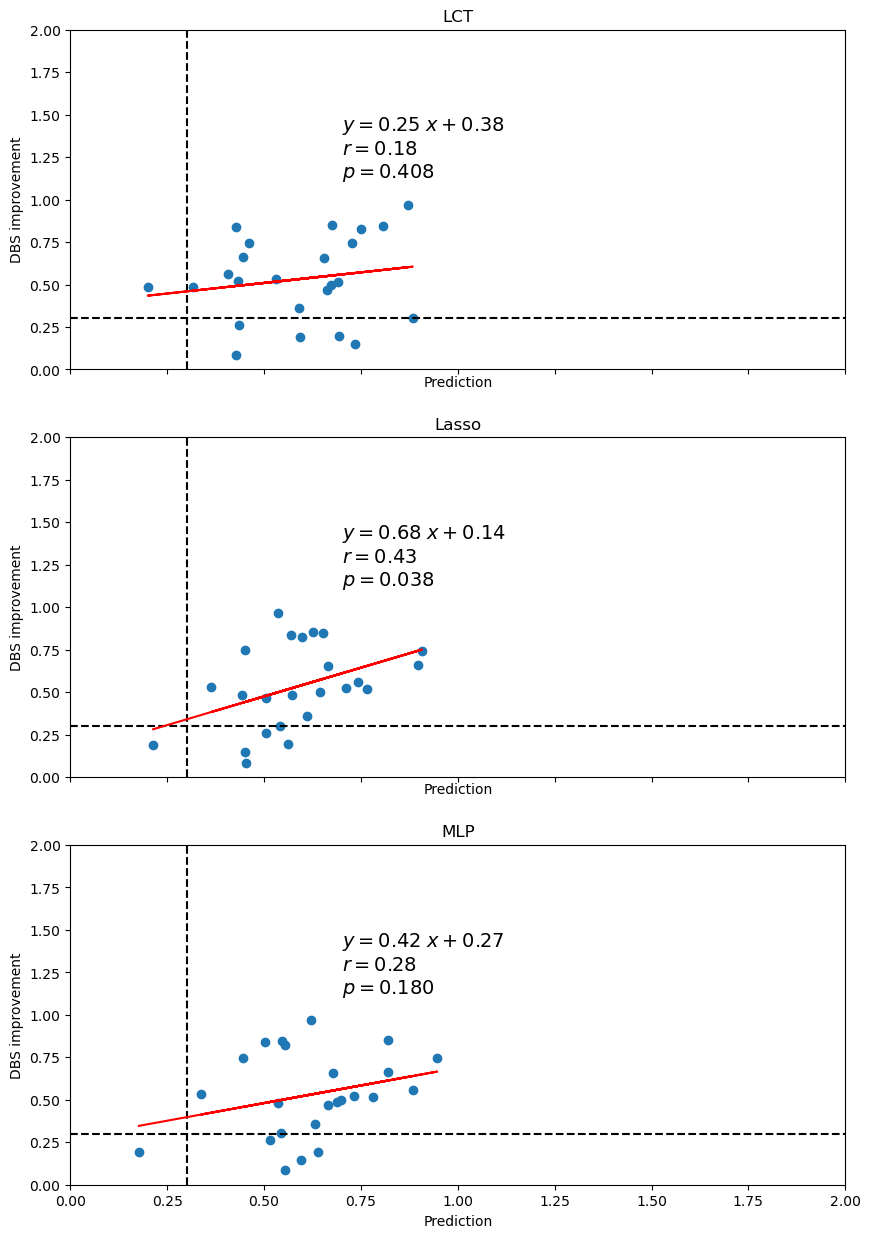

In [77]:
util.eval_prediction(np.vstack((pre_imps,
                               results_lsm,
                               results_blsm,
                               )),
                               per_changes,
                               ['LCT',
                                'Lasso',
                                'MLP'
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])



In [78]:
# plt.plot(np.linspace(1,num_epochs,num_epochs),np.mean(curves[0,:,:],axis=0),np.linspace(1,num_epochs,num_epochs),np.mean(curves[1,:,:],axis=0))
# plt.fill_between(np.linspace(1,num_epochs,num_epochs), np.mean(curves[0,:,:],axis=0)-np.std(curves[0,:,:],axis=0),np.mean(curves[0,:,:],axis=0)+np.std(curves[0,:,:],axis=0),
#                  color='blue', alpha=0.2)
# plt.fill_between(np.linspace(1,num_epochs,num_epochs), np.mean(curves[1,:,:],axis=0)-np.std(curves[1,:,:],axis=0),np.mean(curves[1,:,:],axis=0)+np.std(curves[1,:,:],axis=0),
#                  color='orange', alpha=0.2)
# plt.title('Convergence')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# #plt.ylim([-0,0.5])
# plt.legend(['Training','Validation'])
# plt.show()
# plt.style.use('dark_background')